## Module 2 — Regional Distribution of Global Clinical Trial Initiations

Fetching trials by country/region with pagination (2015–2025)...

Year 2015: totalCount=24,104, pageSize=200, expected_pages≈121
Year 2015: fetched 24104 studies...
Year 2015 done. uniqueTrials=24,104, included=24,104, withLoc=20,717, noLoc=3,387, unmappedCountries=91

Year 2016: totalCount=27,785, pageSize=200, expected_pages≈139
Year 2016: fetched 27785 studies...
Year 2016 done. uniqueTrials=27,785, included=27,785, withLoc=23,508, noLoc=4,277, unmappedCountries=92

Year 2017: totalCount=29,175, pageSize=200, expected_pages≈146
Year 2017: fetched 29175 studies...
Year 2017 done. uniqueTrials=29,175, included=29,175, withLoc=25,408, noLoc=3,767, unmappedCountries=97

Year 2018: totalCount=30,945, pageSize=200, expected_pages≈155
Year 2018: fetched 30945 studies...
Year 2018 done. uniqueTrials=30,945, included=30,945, withLoc=27,761, noLoc=3,184, unmappedCountries=98

Year 2019: totalCount=32,510, pageSize=200, expected_pages≈163
Year 2019: fetched 32510 studies...
Year 2019 done. uni

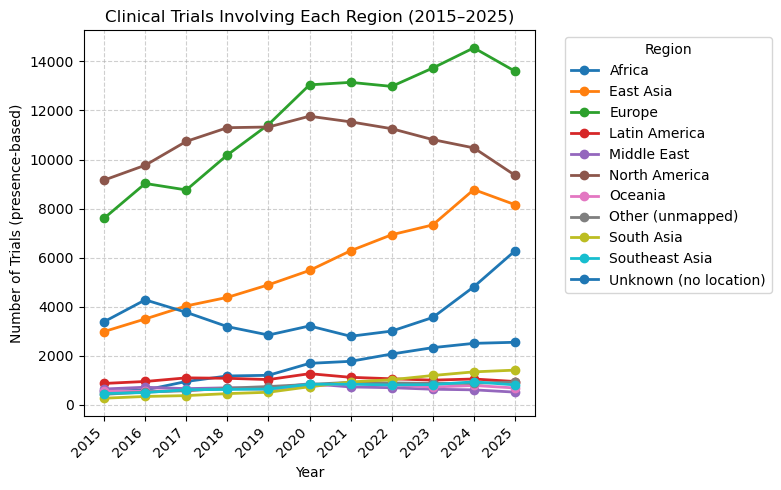

Saved regional trial counts figure to: ../figures/regional_trial_counts_2015_2025.png
Saved Unknown/Other share table to: ../data/processed/unknown_other_share_2015_2025.csv


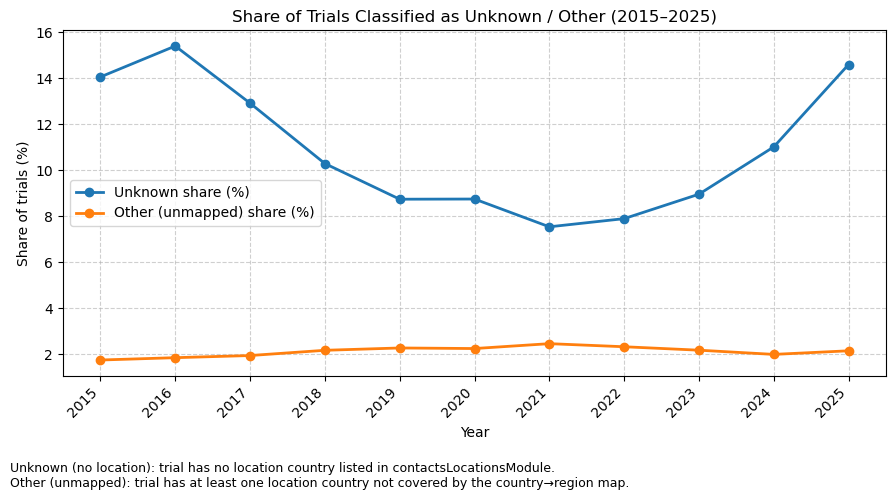

Saved Unknown/Other share figure to: ../figures/unknown_other_share_2015_2025.png


In [7]:
# Module 2 — Trial counts by Country and Region + Collaboration (2015–2025)
import os
import math
import time
import random
import requests
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Paths and API base URL
# =========================
PROCESSED_DIR = "../data/processed"
FIG_DIR = "../figures"
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

BASE_URL = "https://clinicaltrials.gov/api/v2/studies"

# =========================
# Country name normalization (aliases)
# =========================
alias_map = {
    # Your Step A findings / common variants
    "South Korea": "Korea, Republic of",
    "Turkey (Türkiye)": "Turkey",
    "Russia": "Russian Federation",
    "Viet Nam": "Vietnam",
    "Iran, Islamic Republic of": "Iran",
    # add more if you see them later
}

def normalize_country(c: str) -> str:
    return alias_map.get(c, c)

# =========================
# Country → Region mapping (expanded)
# =========================
region_map = {
    # North America
    "United States": "North America",
    "Canada": "North America",
    "Puerto Rico": "North America",

    # Europe (original + expanded)
    "Germany": "Europe",
    "France": "Europe",
    "United Kingdom": "Europe",
    "Italy": "Europe",
    "Spain": "Europe",
    "Netherlands": "Europe",
    "Sweden": "Europe",
    "Belgium": "Europe",
    "Switzerland": "Europe",
    "Denmark": "Europe",
    "Norway": "Europe",
    "Finland": "Europe",
    "Poland": "Europe",
    "Austria": "Europe",
    "Czechia": "Europe",
    "Czech Republic": "Europe",

    # Expanded from your Top unmapped list
    "Turkey": "Europe",
    "Russian Federation": "Europe",
    "Greece": "Europe",
    "Hungary": "Europe",
    "Portugal": "Europe",
    "Bulgaria": "Europe",
    "Romania": "Europe",
    "Ireland": "Europe",
    "Ukraine": "Europe",
    "Slovakia": "Europe",
    "Serbia": "Europe",
    "Croatia": "Europe",
    "Lithuania": "Europe",
    "Slovenia": "Europe",
    "Georgia": "Europe",
    "Estonia": "Europe",
    "Latvia": "Europe",

    # East Asia
    "China": "East Asia",
    "Japan": "East Asia",
    "Korea, Republic of": "East Asia",
    "Hong Kong": "East Asia",
    "Taiwan": "East Asia",

    # South Asia
    "India": "South Asia",
    "Pakistan": "South Asia",
    "Bangladesh": "South Asia",
    "Sri Lanka": "South Asia",

    # Southeast Asia (new region)
    "Singapore": "Southeast Asia",
    "Thailand": "Southeast Asia",
    "Malaysia": "Southeast Asia",
    "Indonesia": "Southeast Asia",
    "Vietnam": "Southeast Asia",
    "Philippines": "Southeast Asia",

    # Middle East (new region)
    "Israel": "Middle East",
    "Saudi Arabia": "Middle East",
    "Lebanon": "Middle East",
    "Iran": "Middle East",

    # Latin America
    "Brazil": "Latin America",
    "Mexico": "Latin America",
    "Argentina": "Latin America",
    "Chile": "Latin America",
    "Colombia": "Latin America",
    "Peru": "Latin America",

    # Africa
    "South Africa": "Africa",
    "Kenya": "Africa",
    "Egypt": "Africa",
    "Nigeria": "Africa",
    "Ghana": "Africa",
    "Uganda": "Africa",

    # Oceania
    "Australia": "Oceania",
    "New Zealand": "Oceania",
}

def map_region(country: str) -> str:
    if country == "Unknown (no location)":
        return "Unknown (no location)"
    return region_map.get(country, "Other (unmapped)")

# =========================
# Years and paging
# =========================
YEARS = list(range(2015, 2026))   # 2015–2025
PAGE_SIZE = 200

TIMEOUT = (10, 180)   # (connect_timeout, read_timeout)
MAX_RETRIES = 6
BASE_SLEEP = 1.0

def get_with_retry(session: requests.Session, url: str, params: dict):
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            resp = session.get(url, params=params, timeout=TIMEOUT)
            if resp.status_code in (429, 500, 502, 503, 504):
                raise requests.HTTPError(f"HTTP {resp.status_code}", response=resp)
            resp.raise_for_status()
            return resp
        except (
            requests.exceptions.ReadTimeout,
            requests.exceptions.ConnectTimeout,
            requests.exceptions.ConnectionError,
            requests.exceptions.HTTPError
        ) as e:
            if attempt == MAX_RETRIES:
                raise
            sleep = BASE_SLEEP * (2 ** (attempt - 1)) + random.random() * 0.5
            print(f"\n  [retry] attempt {attempt}/{MAX_RETRIES} failed: {type(e).__name__} -> sleep {sleep:.1f}s")
            time.sleep(sleep)

# =========================
# Main fetch
# =========================
records = []
coverage_rows = []
unmapped_countries_all = set()

print("Fetching trials by country/region with pagination (2015–2025)...")

with requests.Session() as session:
    session.headers.update({"User-Agent": "trial-analysis/1.0 (contact: research)"})

    for year in YEARS:
        start, end = f"{year}-01-01", f"{year}-12-31"
        page_token = None

        fetched_studies = 0
        total_count = None

        seen_trials = set()
        included_trials = set()
        trials_with_locations = set()
        trials_without_locations = set()
        unmapped_countries_this_year = set()

        while True:
            params = {
                "query.term": f"AREA[StudyFirstPostDate]RANGE[{start},{end}]",
                "pageSize": PAGE_SIZE,
                "format": "json",
                "countTotal": "true",
            }
            if page_token:
                params["pageToken"] = page_token

            r = get_with_retry(session, BASE_URL, params)
            data = r.json()

            if total_count is None:
                total_count = data.get("totalCount", 0)
                expected_pages = math.ceil(total_count / PAGE_SIZE) if PAGE_SIZE else None
                print(f"\nYear {year}: totalCount={total_count:,}, pageSize={PAGE_SIZE}, expected_pages≈{expected_pages}")

            studies = data.get("studies", [])
            if not studies:
                break

            for study in studies:
                protocol = study.get("protocolSection", {})
                ident = protocol.get("identificationModule", {})
                nct_id = ident.get("nctId")
                if not nct_id:
                    continue

                seen_trials.add(nct_id)

                contacts = protocol.get("contactsLocationsModule", {})
                locs = contacts.get("locations", [])

                # normalize + set-dedup
                countries = {
                    normalize_country(loc.get("country"))
                    for loc in locs
                    if loc.get("country")
                }

                if not countries:
                    trials_without_locations.add(nct_id)
                    records.append({"Year": year, "NCTId": nct_id, "Country": "Unknown (no location)"})
                    included_trials.add(nct_id)
                    continue

                trials_with_locations.add(nct_id)

                for c in countries:
                    records.append({"Year": year, "NCTId": nct_id, "Country": c})
                    included_trials.add(nct_id)
                    if c not in region_map:
                        unmapped_countries_this_year.add(c)
                        unmapped_countries_all.add(c)

            fetched_studies += len(studies)
            print(f"Year {year}: fetched {fetched_studies} studies...", end="\r")

            page_token = data.get("nextPageToken")
            if not page_token:
                break

        fetch_ratio = (fetched_studies / total_count) if total_count else None
        include_ratio = (len(included_trials) / total_count) if total_count else None

        coverage_rows.append({
            "Year": year,
            "TotalCount(API)": total_count or 0,
            "FetchedStudies(pages)": fetched_studies,
            "FetchCoverage(approx)": fetch_ratio,
            "UniqueTrialsSeen": len(seen_trials),
            "IncludedTrials": len(included_trials),
            "IncludedCoverage": include_ratio,
            "TrialsWithLocations": len(trials_with_locations),
            "TrialsWithoutLocations": len(trials_without_locations),
            "UnmappedCountriesCount": len(unmapped_countries_this_year),
        })

        print(f"\nYear {year} done. uniqueTrials={len(seen_trials):,}, included={len(included_trials):,}, "
              f"withLoc={len(trials_with_locations):,}, noLoc={len(trials_without_locations):,}, "
              f"unmappedCountries={len(unmapped_countries_this_year):,}")

# =========================
# Build DataFrame
# =========================
df = pd.DataFrame(records)
df = df.drop_duplicates(subset=["Year", "NCTId", "Country"])
df["Region"] = df["Country"].map(map_region)

fact_path = os.path.join(PROCESSED_DIR, "trial_country_fact_2015_2025.csv")
df.to_csv(fact_path, index=False)
print("\nSaved trial-country fact table to:", fact_path)

# Trial count by country
agg_country = (
    df.groupby(["Year", "Country"])["NCTId"].nunique()
    .reset_index(name="TrialCount")
    .sort_values(["Year", "TrialCount"], ascending=[True, False])
)
country_path = os.path.join(PROCESSED_DIR, "trialcount_by_country_2015_2025.csv")
agg_country.to_csv(country_path, index=False)
print("Saved trial count by country to:", country_path)

# Trial count by region
agg_region = (
    df.groupby(["Year", "Region"])["NCTId"].nunique()
    .reset_index(name="TrialCount")
    .sort_values(["Year", "Region"])
)
region_path = os.path.join(PROCESSED_DIR, "trialcount_by_region_2015_2025.csv")
agg_region.to_csv(region_path, index=False)
print("Saved trial count by region to:", region_path)

# Single vs multi-region
trial_regions = df.groupby(["Year", "NCTId"])["Region"].nunique().reset_index(name="NumRegions")
region_summary = (
    trial_regions.groupby("Year")["NumRegions"]
    .agg(
        total_trials="count",
        single_region=lambda x: (x == 1).sum(),
        multi_region=lambda x: (x >= 2).sum(),
    )
    .reset_index()
)
summary_path = os.path.join(PROCESSED_DIR, "trial_single_vs_multi_region_2015_2025.csv")
region_summary.to_csv(summary_path, index=False)
print("Saved single vs multi-region summary to:", summary_path)

# Coverage + unmapped outputs
coverage_df = pd.DataFrame(coverage_rows)
coverage_path = os.path.join(PROCESSED_DIR, "coverage_report_2015_2025.csv")
coverage_df.to_csv(coverage_path, index=False)
print("Saved coverage report to:", coverage_path)

unmapped_df = pd.DataFrame(sorted(unmapped_countries_all), columns=["UnmappedCountry"])
unmapped_path = os.path.join(PROCESSED_DIR, "unmapped_countries_2015_2025.csv")
unmapped_df.to_csv(unmapped_path, index=False)
print("Saved unmapped countries list to:", unmapped_path)

# =========================
# Plot A: Region trend (counts) - keep your original
# =========================
plt.figure(figsize=(8, 5))
regions = sorted(agg_region["Region"].unique())
for reg in regions:
    sub = agg_region[agg_region["Region"] == reg]
    plt.plot(sub["Year"], sub["TrialCount"], marker="o", linewidth=2, label=reg)

plt.title("Clinical Trials Involving Each Region (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Number of Trials (presence-based)")
plt.grid(True, linestyle="--", alpha=0.6)

years = sorted(agg_region["Year"].unique())
ax = plt.gca()
ax.set_xticks(years)
ax.set_xticklabels([str(y) for y in years], rotation=45, ha="right")

plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
fig_counts_path = os.path.join(FIG_DIR, "regional_trial_counts_2015_2025.png")
plt.savefig(fig_counts_path)
plt.show()
print("Saved regional trial counts figure to:", fig_counts_path)

# =========================
# Plot B: UnknownShare & OtherShare over time (percent)
# =========================
# trial-level (unique NCTId) shares by year
total_trials = df.groupby("Year")["NCTId"].nunique()

unknown_trials = (
    df[df["Region"] == "Unknown (no location)"]
    .groupby("Year")["NCTId"].nunique()
)

other_trials = (
    df[df["Region"] == "Other (unmapped)"]
    .groupby("Year")["NCTId"].nunique()
)

share_df = pd.DataFrame({
    "TotalTrials": total_trials,
    "UnknownTrials": unknown_trials,
    "OtherTrials": other_trials
}).fillna(0)

share_df["UnknownShare"] = share_df["UnknownTrials"] / share_df["TotalTrials"] * 100.0
share_df["OtherShare"] = share_df["OtherTrials"] / share_df["TotalTrials"] * 100.0

share_csv = os.path.join(PROCESSED_DIR, "unknown_other_share_2015_2025.csv")
share_df.reset_index().to_csv(share_csv, index=False)
print("Saved Unknown/Other share table to:", share_csv)

plt.figure(figsize=(9, 5))
plt.plot(share_df.index, share_df["UnknownShare"], marker="o", linewidth=2, label="Unknown share (%)")
plt.plot(share_df.index, share_df["OtherShare"], marker="o", linewidth=2, label="Other (unmapped) share (%)")

plt.title("Share of Trials Classified as Unknown / Other (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Share of trials (%)")
plt.grid(True, linestyle="--", alpha=0.6)

ax = plt.gca()
ax.set_xticks(share_df.index.tolist())
ax.set_xticklabels([str(y) for y in share_df.index.tolist()], rotation=45, ha="right")

plt.legend()

# Add footnotes at bottom
note1 = "Unknown (no location): trial has no location country listed in contactsLocationsModule."
note2 = "Other (unmapped): trial has at least one location country not covered by the country→region map."
plt.figtext(0.01, 0.01, note1 + "\n" + note2, ha="left", va="bottom", fontsize=9)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave room for notes
fig_share_path = os.path.join(FIG_DIR, "unknown_other_share_2015_2025.png")
plt.savefig(fig_share_path, dpi=200)
plt.show()
print("Saved Unknown/Other share figure to:", fig_share_path)



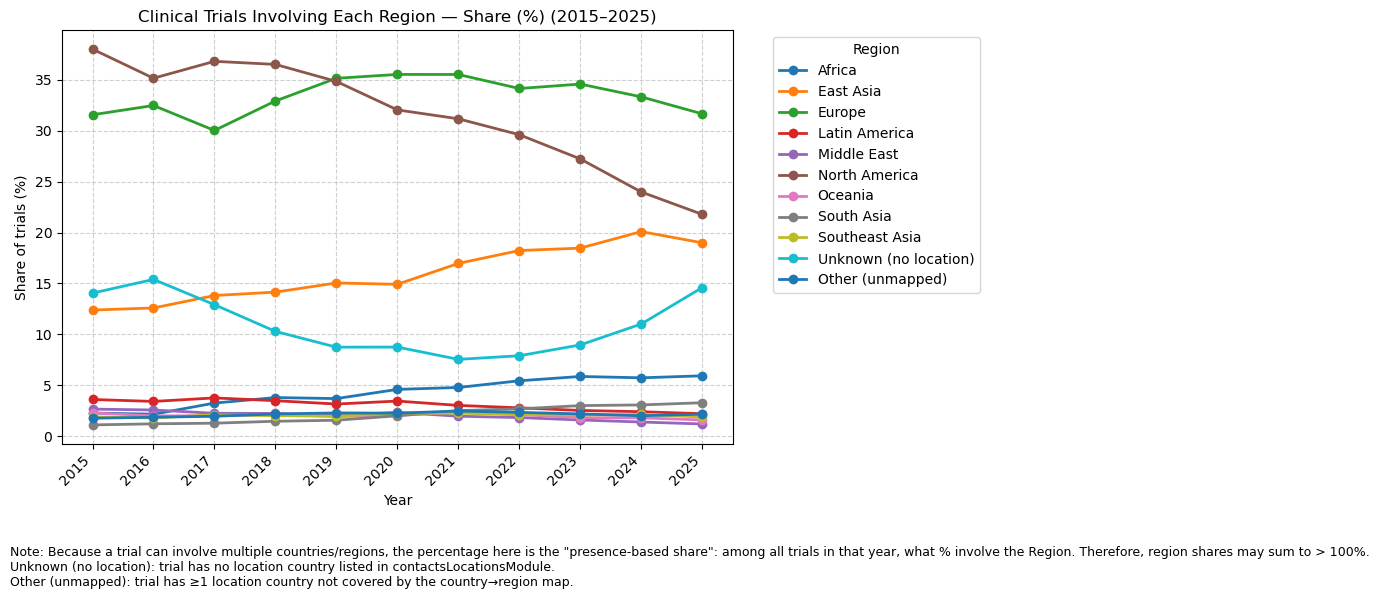

Saved percent-share figure to: ../figures/regional_trial_share_percent_2015_2025.png


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the trial-level fact table saved by Module 2 (one row per Year–NCTId–Country, with Region already assigned)
df = pd.read_csv("../data/processed/trial_country_fact_2015_2025.csv")

# Total unique trials per year (trial-level denominator)
total_trials = df.groupby("Year")["NCTId"].nunique()

# Trial counts per Year × Region (trial-level presence: a trial contributes at most 1 count to a given Region)
region_trials = (
    df.groupby(["Year", "Region"])["NCTId"].nunique()
    .unstack(fill_value=0)
)

# Convert counts to percentages:
# For each year, % of trials that involve each Region (presence-based share)
pct = region_trials.div(total_trials, axis=0) * 100.0

# Plot percentage trends
plt.figure(figsize=(10, 6))
years = pct.index.tolist()

# Optional: move "Unknown" and "Other" lines to the end so the main regions are easier to compare
cols = pct.columns.tolist()
for special in ["Unknown (no location)", "Other (unmapped)"]:
    if special in cols:
        cols.remove(special)
        cols.append(special)

for reg in cols:
    plt.plot(years, pct[reg], marker="o", linewidth=2, label=reg)

plt.title("Clinical Trials Involving Each Region — Share (%) (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Share of trials (%)")
plt.grid(True, linestyle="--", alpha=0.6)

ax = plt.gca()
ax.set_xticks(years)
ax.set_xticklabels([str(y) for y in years], rotation=45, ha="right")

plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")

# Footnotes under the chart (3 lines as requested)
note1 = (
    'Note: Because a trial can involve multiple countries/regions, the percentage here is the '
    '"presence-based share": among all trials in that year, what % involve the Region. '
    "Therefore, region shares may sum to > 100%."
)
note2 = (
    "Unknown (no location): trial has no location country listed in contactsLocationsModule."
)
note3 = (
    "Other (unmapped): trial has ≥1 location country not covered by the country→region map."
)

plt.figtext(0.01, 0.01, note1 + "\n" + note2 + "\n" + note3, ha="left", va="bottom", fontsize=9)

# Leave space for the footnotes
plt.tight_layout(rect=[0, 0.12, 1, 1])

out_path = "../figures/regional_trial_share_percent_2015_2025.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved percent-share figure to:", out_path)